In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, Input, Lambda, GlobalAveragePooling2D, Concatenate, PReLU, LeakyReLU
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
import sklearn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
from os import listdir
from tqdm import tqdm
import shutil
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import time
import itertools

In [3]:
print(tf.__version__)
print(tf.keras.__version__)

2.16.2
3.4.1


In [4]:
epochs = 50

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger('Model.log')

callbacks = [earlystop, csv_logger, reduce_lr]

In [5]:
# Intersection over Union (IoU)
def iou(y_true, y_pred, smooth=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [6]:
# Sensitivity
def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [7]:
# Specificity
def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [8]:
# Dice coefficient metric
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice_score = (2.0 * intersection + epsilon) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + epsilon)
    return dice_score

In [9]:
def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [10]:
def confusion_matrix_img(y_pred, y_true, savename):
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    labels = ['benign', 'malignant']
    title='Confusion matrix'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

In [11]:
size = 128
os.makedirs('augmented/benign', exist_ok=True)
os.makedirs('augmented/malignant', exist_ok=True)

def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

In [12]:
files_benign = getListOfFiles('/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f, 'augmented/benign')


files_malignant = getListOfFiles('/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f, 'augmented/malignant')

benign_images = getListOfFiles('augmented/benign')
malignent_images = getListOfFiles('augmented/malignant')

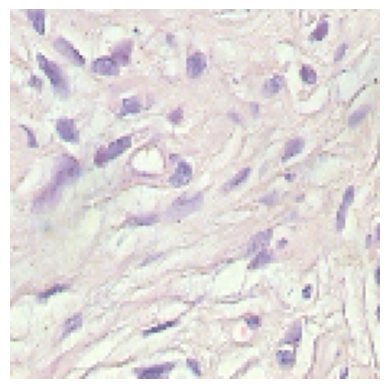

In [13]:
image_path = benign_images[9]
img = load_img(image_path, target_size=(size, size), color_mode='rgb')
img_array = img_to_array(img)
plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.show()

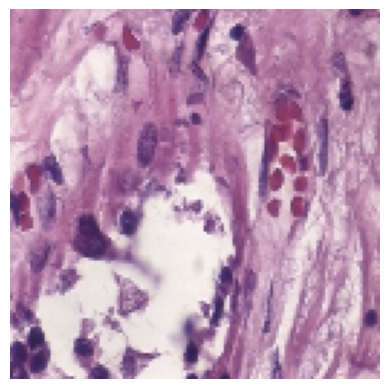

In [14]:
image_path = malignent_images[45]
img = load_img(image_path, target_size=(size, size), color_mode='rgb')
img_array = img_to_array(img)
plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.show()

In [15]:
total_images = len(benign_images) + len(malignent_images)
data = pd.DataFrame(index=np.arange(0, total_images), columns=["image", "target"])

k = 0
for c, image_list in enumerate([benign_images, malignent_images]):
    for image_path in image_list:
        data.loc[k, "image"] = image_path
        data.loc[k, "target"] = c
        k += 1

print(data.shape)
print(data.head())

count_data = data["target"].value_counts()
ben_upsampled = resample(data[data['target']==0], n_samples=data[data['target']==1].shape[0], random_state=42)
up_sampled = pd.concat([data[data['target']==1], ben_upsampled])
up_sampled['target'].value_counts()

(7909, 2)
                                             image target
0  augmented/benign/SOB_B_F-14-23060CD-100-001.png      0
1  augmented/benign/SOB_B_TA-14-19854C-200-016.png      0
2  augmented/benign/SOB_B_TA-14-19854C-200-002.png      0
3    augmented/benign/SOB_B_F-14-25197-400-039.png      0
4   augmented/benign/SOB_B_F-14-14134E-100-007.png      0


target
1    5429
0    5429
Name: count, dtype: int64

In [16]:
train_image = []
y = []

for i in tqdm(range(up_sampled.shape[0])):
    img = tf.keras.utils.load_img(up_sampled['image'].iloc[i], target_size=(size, size), color_mode='rgb')
    img = tf.keras.utils.img_to_array(img)
    img = img / 255.0
    train_image.append(img)
        
X = np.array(train_image)
y = up_sampled.iloc[:, -1].values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10858/10858 [01:04<00:00, 169.54it/s]


In [17]:
# KFold split
kf = KFold(n_splits=10, random_state=42, shuffle=True)

for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

for train_index, test_index in kf.split(X_test, y_test):
    X2_test, X_val, y2_test, y_val = X_test[train_index], X_test[test_index], y_test[train_index], y_test[test_index]

Y_train = to_categorical(y_train, 2)
Y_test = to_categorical(y2_test, 2)
Y_val = to_categorical(y_val, 2)

print(X_train.shape)
print(X2_test.shape)
print(X_val.shape)

data_gen = ImageDataGenerator(
    zoom_range=1.2,  
    rotation_range=90,
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,  
    vertical_flip=True, 
)

data_gen.fit(X_train)
data_gen.fit(X_val)
data_gen.fit(X2_test)

(9773, 128, 128, 3)
(977, 128, 128, 3)
(108, 128, 128, 3)


In [18]:
# GAN Architecture
def build_generator(noise_dim, img_shape):
    model = Sequential()
    
    model.add(Dense(256, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    noise = Input(shape=(noise_dim,))
    img = model(noise)

    return Model(noise, img)

def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [19]:
img_shape = (size, size, 3)
noise_dim = 100

In [20]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [21]:
generator = build_generator(noise_dim, img_shape)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
z = Input(shape=(noise_dim,))
img = generator(z)

In [23]:
# For the combined model, we only train the generator
discriminator.trainable = False

In [24]:
# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

In [25]:
# The combined model 
gan = Model(z, valid)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [26]:
def train_gan(epochs, batch_size, save_interval):
    
    X_train_gan = X_train * 2 - 1  
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train_gan.shape[0], batch_size)
        imgs = X_train_gan[idx]

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        g_loss = gan.train_on_batch(noise, valid)

        
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        
        if epoch % save_interval == 0:
            save_imgs(epoch)

def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [27]:
train_gan(epochs=50, batch_size=16, save_interval=200)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.42821094393730164 | D accuracy: 79.6875] [G loss: [array(0.5208515, dtype=float32), array(0.5208515, dtype=float32), array(0.59375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1 [D loss: 0.492206335067749 | D accuracy: 66.14583730697632] [G loss: [array(0.5299934, dtype=float32), array(0.5299934, dtype=float32), array(0.59375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2 [D loss: 0.5193188786506653 | D accuracy: 62.39583492279053] [G loss: [array(0.5546364, dtype=float32), array(0.5546364, dtype=float32), array(0.5729167, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3 [D loss: 0.5602620840072632 | D accuracy: 58.984375] [G loss: [array(0.596298, dtype=float32), array(0.596298, dtype=float32), array(0.5546875, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4 [D loss: 0.6101735830307007 | D accuracy: 56.736111640930176] [G loss: [array(0.6516506, dtype=float32), array(0.6516506, dtype=float32), a

In [28]:
def generate_images(generator, num_images, noise_dim):
    noise = np.random.normal(0, 1, (num_images, noise_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    return gen_imgs

In [29]:
num_synthetic_images = 1000
synthetic_images = generate_images(generator, num_synthetic_images, noise_dim)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [30]:
X_train_augmented = np.concatenate((X_train, synthetic_images))
y_train_augmented = np.concatenate((y_train, np.full((num_synthetic_images,), 1)))  # Assuming class 1 for synthetic images

In [31]:
Y_train_augmented = to_categorical(y_train_augmented, 2)

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [32]:
def bottleneck0(inputs):
    backbone = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    x = backbone(inputs)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)  # Bottleneck layer with EfficientNet
    x = Flatten()(x)
    return x

In [33]:
def neck_section(inputs):
    x = Conv2D(256, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = PReLU()(x)  # Use PReLU directly as a layer
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Flatten()(x)
    return x

In [34]:
def vision_transform(inputs, patch_size):
    x = Reshape((patch_size[0], patch_size[1], -1))(inputs)
    x = Lambda(lambda image: tf.cast(image, 'float32') / 255.0)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return x

In [35]:
def create_model(input_shape, num_classes, patch_size):
    inputs = Input(shape=input_shape)
    efficientnet_bottleneck = bottleneck0(inputs)
    patches_transform = vision_transform(inputs, patch_size)
    neck = neck_section(inputs)
    merged = Concatenate()([efficientnet_bottleneck, patches_transform, neck])
    outputs = Dense(num_classes, activation='softmax')(merged)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [36]:
input_shape = (size, size, 3)
num_classes = 2
patch_size = (32, 32)
batch_size = 16

with strategy.scope():
    model = create_model(input_shape, num_classes, patch_size)
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(name='AUC'),
                           f1_score, specificity, sensitivity, iou, tversky])

print(model.input_shape)
print(model.output_shape)
model.summary()

(None, 128, 128, 3)
(None, 2)


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 32, 32,    │          0 │ input_layer_5[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 32, 32,    │          0 │ reshape_1[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │     27,712 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 4, 4,      │  5,919,312 │ input_layer_5[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     37,888 │ input_layer_5[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1280)      │      5,120 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 10, 10,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 64, 64,    │  1,048,576 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │    327,936 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ p_re_lu[0][0]     │
│ (MaxPooling2D)      │ 256)              │            │                 

 Total params: 8,157,138 (31.12 MB)

 Trainable params: 8,093,458 (30.87 MB)

 Non-trainable params: 63,680 (248.75 KB)

In [37]:
start_time = time.time()
history = model.fit(data_gen.flow(X_train_augmented, Y_train_augmented,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=True),
                    callbacks=callbacks,
                    epochs=50,
                    steps_per_epoch=X_train_augmented.shape[0] // batch_size,
                    validation_data=data_gen.flow(X_val, Y_val,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=True))
end_time = time.time()

print("Training time: {:.2f} seconds".format(end_time - start_time))
model.save("modelBH.h5")
print("Saved model to disk")

df = pd.DataFrame(history.history) 
df.to_excel("output.xlsx")
df.head(50)

Epoch 1/50


2024-07-27 02:18:19.556911: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - AUC: 0.6706 - accuracy: 0.6616 - f1_score: 0.6615 - iou: 0.5213 - loss: 17.0791 - precision: 0.6616 - recall: 0.6616 - sensitivity: 0.6615 - specificity: 0.6615 - tversky: 0.6805

2024-07-27 02:23:19.747547: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 302s 429ms/step - AUC: 0.6706 - accuracy: 0.6616 - f1_score: 0.6616 - iou: 0.5213 - loss: 17.0728 - precision: 0.6616 - recall: 0.6616 - sensitivity: 0.6616 - specificity: 0.6616 - tversky: 0.6805 - val_AUC: 0.5421 - val_accuracy: 0.5463 - val_f1_score: 0.5536 - val_iou: 0.4125 - val_loss: 26.1052 - val_precision: 0.5463 - val_recall: 0.5463 - val_sensitivity: 0.5536 - val_specificity: 0.5536 - val_tversky: 0.5804 - learning_rate: 0.0010
Epoch 2/50


2024-07-27 02:23:21.241812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 02:23:21.395656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:44 513ms/step - AUC: 0.8125 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6923 - loss: 3.8908 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.8235

2024-07-27 02:23:21.909065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]
/opt/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8125 - accuracy: 0.8125 - f1_score: 0.4069 - iou: 0.3467 - loss: 3.8908 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4069 - specificity: 0.4069 - tversky: 0.4124 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5357 - val_iou: 0.3869 - val_loss: 36.2507 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5357 - val_specificity: 0.5357 - val_tversky: 0.5643 - learning_rate: 0.0010
Epoch 3/50


2024-07-27 02:23:22.585257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - AUC: 0.7233 - accuracy: 0.7084 - f1_score: 0.7085 - iou: 0.5735 - loss: 10.0082 - precision: 0.7084 - recall: 0.7084 - sensitivity: 0.7085 - specificity: 0.7085 - tversky: 0.7247

2024-07-27 02:28:33.240665: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 311s 462ms/step - AUC: 0.7233 - accuracy: 0.7084 - f1_score: 0.7085 - iou: 0.5735 - loss: 10.0050 - precision: 0.7084 - recall: 0.7084 - sensitivity: 0.7085 - specificity: 0.7085 - tversky: 0.7248 - val_AUC: 0.5749 - val_accuracy: 0.5926 - val_f1_score: 0.5952 - val_iou: 0.4382 - val_loss: 11.7700 - val_precision: 0.5926 - val_recall: 0.5926 - val_sensitivity: 0.5952 - val_specificity: 0.5952 - val_tversky: 0.6121 - learning_rate: 0.0010
Epoch 4/50


2024-07-27 02:28:33.967570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 02:28:34.109206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:00 536ms/step - AUC: 0.5664 - accuracy: 0.5625 - f1_score: 0.5625 - iou: 0.4025 - loss: 7.3659 - precision: 0.5625 - recall: 0.5625 - sensitivity: 0.5625 - specificity: 0.5625 - tversky: 0.5865

2024-07-27 02:28:34.647359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.5664 - accuracy: 0.5625 - f1_score: 0.2817 - iou: 0.2016 - loss: 7.3659 - precision: 0.5625 - recall: 0.5625 - sensitivity: 0.2817 - specificity: 0.2817 - tversky: 0.2937 - val_AUC: 0.4846 - val_accuracy: 0.4722 - val_f1_score: 0.4702 - val_iou: 0.3320 - val_loss: 8.6017 - val_precision: 0.4722 - val_recall: 0.4722 - val_sensitivity: 0.4702 - val_specificity: 0.4702 - val_tversky: 0.5083 - learning_rate: 0.0010
Epoch 5/50


2024-07-27 02:28:35.427963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - AUC: 0.7488 - accuracy: 0.7161 - f1_score: 0.7161 - iou: 0.5817 - loss: 4.2540 - precision: 0.7161 - recall: 0.7161 - sensitivity: 0.7161 - specificity: 0.7161 - tversky: 0.7329

2024-07-27 02:33:56.776054: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 322s 478ms/step - AUC: 0.7488 - accuracy: 0.7161 - f1_score: 0.7161 - iou: 0.5817 - loss: 4.2537 - precision: 0.7161 - recall: 0.7161 - sensitivity: 0.7161 - specificity: 0.7161 - tversky: 0.7329 - val_AUC: 0.5628 - val_accuracy: 0.5370 - val_f1_score: 0.5417 - val_iou: 0.4035 - val_loss: 10.7893 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5417 - val_specificity: 0.5417 - val_tversky: 0.5767 - learning_rate: 0.0010
Epoch 6/50


2024-07-27 02:33:57.559501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 02:33:57.672607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:48 519ms/step - AUC: 0.7891 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6682 - loss: 2.5939 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.8069

2024-07-27 02:33:58.194220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7891 - accuracy: 0.8125 - f1_score: 0.4069 - iou: 0.3346 - loss: 2.5939 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4069 - specificity: 0.4069 - tversky: 0.4041 - val_AUC: 0.5063 - val_accuracy: 0.4815 - val_f1_score: 0.4881 - val_iou: 0.3531 - val_loss: 8.0222 - val_precision: 0.4815 - val_recall: 0.4815 - val_sensitivity: 0.4881 - val_specificity: 0.4881 - val_tversky: 0.5291 - learning_rate: 0.0010
Epoch 7/50


2024-07-27 02:33:58.945547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - AUC: 0.7450 - accuracy: 0.7135 - f1_score: 0.7129 - iou: 0.5756 - loss: 3.6338 - precision: 0.7135 - recall: 0.7135 - sensitivity: 0.7129 - specificity: 0.7129 - tversky: 0.7280

2024-07-27 02:39:24.557104: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 326s 485ms/step - AUC: 0.7450 - accuracy: 0.7135 - f1_score: 0.7129 - iou: 0.5756 - loss: 3.6330 - precision: 0.7135 - recall: 0.7135 - sensitivity: 0.7129 - specificity: 0.7129 - tversky: 0.7280 - val_AUC: 0.6989 - val_accuracy: 0.6852 - val_f1_score: 0.6815 - val_iou: 0.5275 - val_loss: 4.2146 - val_precision: 0.6852 - val_recall: 0.6852 - val_sensitivity: 0.6815 - val_specificity: 0.6815 - val_tversky: 0.6950 - learning_rate: 0.0010
Epoch 8/50


2024-07-27 02:39:25.294072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 02:39:25.443910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:35 499ms/step - AUC: 0.6250 - accuracy: 0.5000 - f1_score: 0.5000 - iou: 0.3885 - loss: 3.0872 - precision: 0.5000 - recall: 0.5000 - sensitivity: 0.5000 - specificity: 0.5000 - tversky: 0.5726

2024-07-27 02:39:25.946370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.6250 - accuracy: 0.5000 - f1_score: 0.2504 - iou: 0.1946 - loss: 3.0872 - precision: 0.5000 - recall: 0.5000 - sensitivity: 0.2504 - specificity: 0.2504 - tversky: 0.2867 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5357 - val_iou: 0.3932 - val_loss: 12.0580 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5357 - val_specificity: 0.5357 - val_tversky: 0.5643 - learning_rate: 0.0010
Epoch 9/50


2024-07-27 02:39:26.677550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - AUC: 0.7891 - accuracy: 0.7334 - f1_score: 0.7336 - iou: 0.5992 - loss: 1.9806 - precision: 0.7334 - recall: 0.7334 - sensitivity: 0.7336 - specificity: 0.7336 - tversky: 0.7472

2024-07-27 02:44:36.369227: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 310s 461ms/step - AUC: 0.7891 - accuracy: 0.7334 - f1_score: 0.7336 - iou: 0.5992 - loss: 1.9800 - precision: 0.7334 - recall: 0.7334 - sensitivity: 0.7336 - specificity: 0.7336 - tversky: 0.7472 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5327 - val_iou: 0.3835 - val_loss: 29.7696 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5327 - val_specificity: 0.5327 - val_tversky: 0.5617 - learning_rate: 0.0010
Epoch 10/50


2024-07-27 02:44:37.116738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 02:44:37.232740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:51 522ms/step - AUC: 0.8789 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6747 - loss: 1.3739 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.8114

2024-07-27 02:44:37.755934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8789 - accuracy: 0.8125 - f1_score: 0.4069 - iou: 0.3378 - loss: 1.3739 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4069 - specificity: 0.4069 - tversky: 0.4063 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5446 - val_iou: 0.3981 - val_loss: 28.6488 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5446 - val_specificity: 0.5446 - val_tversky: 0.5721 - learning_rate: 0.0010
Epoch 11/50


2024-07-27 02:44:38.596725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - AUC: 0.8160 - accuracy: 0.7472 - f1_score: 0.7474 - iou: 0.6090 - loss: 1.2344 - precision: 0.7472 - recall: 0.7472 - sensitivity: 0.7474 - specificity: 0.7474 - tversky: 0.7563

2024-07-27 02:50:10.718980: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 333s 494ms/step - AUC: 0.8160 - accuracy: 0.7472 - f1_score: 0.7474 - iou: 0.6090 - loss: 1.2342 - precision: 0.7472 - recall: 0.7472 - sensitivity: 0.7474 - specificity: 0.7474 - tversky: 0.7563 - val_AUC: 0.5757 - val_accuracy: 0.5463 - val_f1_score: 0.5565 - val_iou: 0.4149 - val_loss: 4.7897 - val_precision: 0.5463 - val_recall: 0.5463 - val_sensitivity: 0.5565 - val_specificity: 0.5565 - val_tversky: 0.5852 - learning_rate: 0.0010
Epoch 12/50


2024-07-27 02:50:11.403069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 02:50:11.502128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:06 456ms/step - AUC: 0.8359 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6211 - loss: 1.0624 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.7732

2024-07-27 02:50:11.959860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8359 - accuracy: 0.8125 - f1_score: 0.4069 - iou: 0.3110 - loss: 1.0624 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4069 - specificity: 0.4069 - tversky: 0.3872 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5446 - val_iou: 0.4005 - val_loss: 7.9334 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5446 - val_specificity: 0.5446 - val_tversky: 0.5721 - learning_rate: 0.0010
Epoch 13/50


2024-07-27 02:50:12.701935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - AUC: 0.8640 - accuracy: 0.7888 - f1_score: 0.7891 - iou: 0.6333 - loss: 0.6241 - precision: 0.7888 - recall: 0.7888 - sensitivity: 0.7891 - specificity: 0.7891 - tversky: 0.7770

2024-07-27 02:55:43.507279: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 332s 492ms/step - AUC: 0.8641 - accuracy: 0.7888 - f1_score: 0.7891 - iou: 0.6333 - loss: 0.6240 - precision: 0.7888 - recall: 0.7888 - sensitivity: 0.7891 - specificity: 0.7891 - tversky: 0.7770 - val_AUC: 0.8687 - val_accuracy: 0.7963 - val_f1_score: 0.7976 - val_iou: 0.6229 - val_loss: 0.5267 - val_precision: 0.7963 - val_recall: 0.7963 - val_sensitivity: 0.7976 - val_specificity: 0.7976 - val_tversky: 0.7711 - learning_rate: 2.0000e-04
Epoch 14/50


2024-07-27 02:55:44.236960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 02:55:44.391269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:34 498ms/step - AUC: 0.8164 - accuracy: 0.6875 - f1_score: 0.6875 - iou: 0.5618 - loss: 0.5515 - precision: 0.6875 - recall: 0.6875 - sensitivity: 0.6875 - specificity: 0.6875 - tversky: 0.7277

2024-07-27 02:55:44.890705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8164 - accuracy: 0.6875 - f1_score: 0.3443 - iou: 0.2813 - loss: 0.5515 - precision: 0.6875 - recall: 0.6875 - sensitivity: 0.3443 - specificity: 0.3443 - tversky: 0.3644 - val_AUC: 0.8764 - val_accuracy: 0.7593 - val_f1_score: 0.7649 - val_iou: 0.6349 - val_loss: 0.5303 - val_precision: 0.7593 - val_recall: 0.7593 - val_sensitivity: 0.7649 - val_specificity: 0.7649 - val_tversky: 0.7763 - learning_rate: 2.0000e-04
Epoch 15/50


2024-07-27 02:55:45.680051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - AUC: 0.8727 - accuracy: 0.7893 - f1_score: 0.7892 - iou: 0.6244 - loss: 0.5185 - precision: 0.7893 - recall: 0.7893 - sensitivity: 0.7892 - specificity: 0.7892 - tversky: 0.7712

2024-07-27 03:01:11.907154: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 327s 485ms/step - AUC: 0.8727 - accuracy: 0.7893 - f1_score: 0.7892 - iou: 0.6244 - loss: 0.5185 - precision: 0.7893 - recall: 0.7893 - sensitivity: 0.7892 - specificity: 0.7892 - tversky: 0.7712 - val_AUC: 0.8286 - val_accuracy: 0.7870 - val_f1_score: 0.7827 - val_iou: 0.5822 - val_loss: 0.6943 - val_precision: 0.7870 - val_recall: 0.7870 - val_sensitivity: 0.7827 - val_specificity: 0.7827 - val_tversky: 0.7426 - learning_rate: 2.0000e-04
Epoch 16/50


2024-07-27 03:01:12.678780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 03:01:12.788633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:15 469ms/step - AUC: 0.9844 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7948 - loss: 0.1599 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8890

2024-07-27 03:01:13.259549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9844 - accuracy: 0.8750 - f1_score: 0.4382 - iou: 0.3980 - loss: 0.1599 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4382 - specificity: 0.4382 - tversky: 0.4452 - val_AUC: 0.8092 - val_accuracy: 0.7407 - val_f1_score: 0.7351 - val_iou: 0.5812 - val_loss: 0.8018 - val_precision: 0.7407 - val_recall: 0.7407 - val_sensitivity: 0.7351 - val_specificity: 0.7351 - val_tversky: 0.7403 - learning_rate: 2.0000e-04
Epoch 17/50


2024-07-27 03:01:14.047102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - AUC: 0.8795 - accuracy: 0.7972 - f1_score: 0.7971 - iou: 0.6333 - loss: 0.5018 - precision: 0.7972 - recall: 0.7972 - sensitivity: 0.7971 - specificity: 0.7971 - tversky: 0.7773

2024-07-27 03:06:31.208306: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 318s 472ms/step - AUC: 0.8795 - accuracy: 0.7972 - f1_score: 0.7971 - iou: 0.6333 - loss: 0.5018 - precision: 0.7972 - recall: 0.7972 - sensitivity: 0.7971 - specificity: 0.7971 - tversky: 0.7773 - val_AUC: 0.9056 - val_accuracy: 0.8056 - val_f1_score: 0.8095 - val_iou: 0.6644 - val_loss: 0.4297 - val_precision: 0.8056 - val_recall: 0.8056 - val_sensitivity: 0.8095 - val_specificity: 0.8095 - val_tversky: 0.8020 - learning_rate: 2.0000e-04
Epoch 18/50


2024-07-27 03:06:31.949562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 03:06:32.101010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:33 496ms/step - AUC: 0.9023 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.6900 - loss: 0.4839 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8220

2024-07-27 03:06:32.598878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9023 - accuracy: 0.8750 - f1_score: 0.4382 - iou: 0.3455 - loss: 0.4839 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4382 - specificity: 0.4382 - tversky: 0.4116 - val_AUC: 0.9184 - val_accuracy: 0.8519 - val_f1_score: 0.8482 - val_iou: 0.6625 - val_loss: 0.3946 - val_precision: 0.8519 - val_recall: 0.8519 - val_sensitivity: 0.8482 - val_specificity: 0.8482 - val_tversky: 0.8027 - learning_rate: 2.0000e-04
Epoch 19/50


2024-07-27 03:06:33.358260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - AUC: 0.8835 - accuracy: 0.8002 - f1_score: 0.8000 - iou: 0.6346 - loss: 0.4840 - precision: 0.8002 - recall: 0.8002 - sensitivity: 0.8000 - specificity: 0.8000 - tversky: 0.7791

2024-07-27 03:12:01.150631: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 329s 488ms/step - AUC: 0.8835 - accuracy: 0.8002 - f1_score: 0.8000 - iou: 0.6346 - loss: 0.4840 - precision: 0.8002 - recall: 0.8002 - sensitivity: 0.8000 - specificity: 0.8000 - tversky: 0.7791 - val_AUC: 0.9149 - val_accuracy: 0.8333 - val_f1_score: 0.8363 - val_iou: 0.6849 - val_loss: 0.4346 - val_precision: 0.8333 - val_recall: 0.8333 - val_sensitivity: 0.8363 - val_specificity: 0.8363 - val_tversky: 0.8140 - learning_rate: 2.0000e-04
Epoch 20/50


2024-07-27 03:12:01.973605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 03:12:02.125621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 7:55 708ms/step - AUC: 0.9414 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6844 - loss: 0.3192 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.8181

2024-07-27 03:12:02.839882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9414 - accuracy: 0.8125 - f1_score: 0.4069 - iou: 0.3427 - loss: 0.3192 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4069 - specificity: 0.4069 - tversky: 0.4097 - val_AUC: 0.8778 - val_accuracy: 0.8148 - val_f1_score: 0.8155 - val_iou: 0.6606 - val_loss: 0.5959 - val_precision: 0.8148 - val_recall: 0.8148 - val_sensitivity: 0.8155 - val_specificity: 0.8155 - val_tversky: 0.7993 - learning_rate: 2.0000e-04
Epoch 21/50


2024-07-27 03:12:03.733856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - AUC: 0.8868 - accuracy: 0.8063 - f1_score: 0.8063 - iou: 0.6369 - loss: 0.4720 - precision: 0.8063 - recall: 0.8063 - sensitivity: 0.8063 - specificity: 0.8063 - tversky: 0.7808

2024-07-27 03:17:23.035735: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 320s 475ms/step - AUC: 0.8868 - accuracy: 0.8063 - f1_score: 0.8063 - iou: 0.6369 - loss: 0.4720 - precision: 0.8063 - recall: 0.8063 - sensitivity: 0.8063 - specificity: 0.8063 - tversky: 0.7808 - val_AUC: 0.6142 - val_accuracy: 0.5093 - val_f1_score: 0.5149 - val_iou: 0.3884 - val_loss: 2.0471 - val_precision: 0.5093 - val_recall: 0.5093 - val_sensitivity: 0.5149 - val_specificity: 0.5149 - val_tversky: 0.5672 - learning_rate: 2.0000e-04
Epoch 22/50


2024-07-27 03:17:23.861394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 03:17:23.970689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 9:09 818ms/step - AUC: 0.9102 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6373 - loss: 0.3539 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.7850

2024-07-27 03:17:24.797403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9102 - accuracy: 0.8125 - f1_score: 0.4069 - iou: 0.3191 - loss: 0.3539 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4069 - specificity: 0.4069 - tversky: 0.3931 - val_AUC: 0.6121 - val_accuracy: 0.5000 - val_f1_score: 0.4940 - val_iou: 0.3631 - val_loss: 2.0761 - val_precision: 0.5000 - val_recall: 0.5000 - val_sensitivity: 0.4940 - val_specificity: 0.4940 - val_tversky: 0.5439 - learning_rate: 2.0000e-04
Epoch 23/50


2024-07-27 03:17:25.687137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - AUC: 0.8910 - accuracy: 0.8043 - f1_score: 0.8043 - iou: 0.6395 - loss: 0.4553 - precision: 0.8043 - recall: 0.8043 - sensitivity: 0.8043 - specificity: 0.8043 - tversky: 0.7832

2024-07-27 03:23:08.270510: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 23: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
673/673 ━━━━━━━━━━━━━━━━━━━━ 343s 510ms/step - AUC: 0.8910 - accuracy: 0.8043 - f1_score: 0.8043 - iou: 0.6395 - loss: 0.4553 - precision: 0.8043 - recall: 0.8043 - sensitivity: 0.8043 - specificity: 0.8043 - tversky: 0.7832 - val_AUC: 0.6366 - val_accuracy: 0.5833 - val_f1_score: 0.5774 - val_iou: 0.4255 - val_loss: 1.7725 - val_precision: 0.5833 - val_recall: 0.5833 - val_sensitivity: 0.5774 - val_specificity: 0.5774 - val_tversky: 0.6026 - learning_rate: 2.0000e-04
Epoch 24/50


2024-07-27 03:23:09.091829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 03:23:09.201522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:12 555ms/step - AUC: 0.8086 - accuracy: 0.6875 - f1_score: 0.6875 - iou: 0.5636 - loss: 0.6450 - precision: 0.6875 - recall: 0.6875 - sensitivity: 0.6875 - specificity: 0.6875 - tversky: 0.7291

2024-07-27 03:23:09.757903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8086 - accuracy: 0.6875 - f1_score: 0.3443 - iou: 0.2822 - loss: 0.6450 - precision: 0.6875 - recall: 0.6875 - sensitivity: 0.3443 - specificity: 0.3443 - tversky: 0.3651 - val_AUC: 0.6625 - val_accuracy: 0.6019 - val_f1_score: 0.6042 - val_iou: 0.4537 - val_loss: 1.5475 - val_precision: 0.6019 - val_recall: 0.6019 - val_sensitivity: 0.6042 - val_specificity: 0.6042 - val_tversky: 0.6288 - learning_rate: 4.0000e-05
Epoch 25/50


2024-07-27 03:23:10.556514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - AUC: 0.9063 - accuracy: 0.8266 - f1_score: 0.8270 - iou: 0.6540 - loss: 0.4069 - precision: 0.8266 - recall: 0.8266 - sensitivity: 0.8270 - specificity: 0.8270 - tversky: 0.7939

2024-07-27 03:28:45.720577: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 336s 499ms/step - AUC: 0.9063 - accuracy: 0.8266 - f1_score: 0.8270 - iou: 0.6540 - loss: 0.4069 - precision: 0.8266 - recall: 0.8266 - sensitivity: 0.8270 - specificity: 0.8270 - tversky: 0.7939 - val_AUC: 0.9313 - val_accuracy: 0.8796 - val_f1_score: 0.8810 - val_iou: 0.6908 - val_loss: 0.3425 - val_precision: 0.8796 - val_recall: 0.8796 - val_sensitivity: 0.8810 - val_specificity: 0.8810 - val_tversky: 0.8197 - learning_rate: 4.0000e-05
Epoch 26/50


2024-07-27 03:28:46.474278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 03:28:46.639683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:44 512ms/step - AUC: 0.9648 - accuracy: 0.9375 - f1_score: 0.9375 - iou: 0.7415 - loss: 0.2073 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.9375 - specificity: 0.9375 - tversky: 0.8559

2024-07-27 03:28:47.153628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9648 - accuracy: 0.9375 - f1_score: 0.4694 - iou: 0.3713 - loss: 0.2073 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.4694 - specificity: 0.4694 - tversky: 0.4286 - val_AUC: 0.9492 - val_accuracy: 0.9074 - val_f1_score: 0.9107 - val_iou: 0.6983 - val_loss: 0.2919 - val_precision: 0.9074 - val_recall: 0.9074 - val_sensitivity: 0.9107 - val_specificity: 0.9107 - val_tversky: 0.8247 - learning_rate: 4.0000e-05
Epoch 27/50


2024-07-27 03:28:47.927094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - AUC: 0.9076 - accuracy: 0.8300 - f1_score: 0.8300 - iou: 0.6472 - loss: 0.3964 - precision: 0.8300 - recall: 0.8300 - sensitivity: 0.8300 - specificity: 0.8300 - tversky: 0.7889

2024-07-27 03:34:29.190189: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 342s 508ms/step - AUC: 0.9076 - accuracy: 0.8300 - f1_score: 0.8300 - iou: 0.6472 - loss: 0.3964 - precision: 0.8300 - recall: 0.8300 - sensitivity: 0.8300 - specificity: 0.8300 - tversky: 0.7889 - val_AUC: 0.9416 - val_accuracy: 0.8796 - val_f1_score: 0.8780 - val_iou: 0.6682 - val_loss: 0.3152 - val_precision: 0.8796 - val_recall: 0.8796 - val_sensitivity: 0.8780 - val_specificity: 0.8780 - val_tversky: 0.8059 - learning_rate: 4.0000e-05
Epoch 28/50


2024-07-27 03:34:30.125373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 03:34:30.243964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 7:20 655ms/step - AUC: 0.9805 - accuracy: 0.9375 - f1_score: 0.9375 - iou: 0.7178 - loss: 0.2191 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.9375 - specificity: 0.9375 - tversky: 0.8406

2024-07-27 03:34:30.902401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9805 - accuracy: 0.9375 - f1_score: 0.4694 - iou: 0.3595 - loss: 0.2191 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.4694 - specificity: 0.4694 - tversky: 0.4209 - val_AUC: 0.9423 - val_accuracy: 0.8704 - val_f1_score: 0.8720 - val_iou: 0.6766 - val_loss: 0.3027 - val_precision: 0.8704 - val_recall: 0.8704 - val_sensitivity: 0.8720 - val_specificity: 0.8720 - val_tversky: 0.8121 - learning_rate: 4.0000e-05
Epoch 29/50


2024-07-27 03:34:31.788728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - AUC: 0.9187 - accuracy: 0.8373 - f1_score: 0.8374 - iou: 0.6625 - loss: 0.3681 - precision: 0.8373 - recall: 0.8373 - sensitivity: 0.8374 - specificity: 0.8374 - tversky: 0.7997

2024-07-27 03:40:18.631807: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 348s 516ms/step - AUC: 0.9187 - accuracy: 0.8373 - f1_score: 0.8374 - iou: 0.6625 - loss: 0.3681 - precision: 0.8373 - recall: 0.8373 - sensitivity: 0.8374 - specificity: 0.8374 - tversky: 0.7997 - val_AUC: 0.9633 - val_accuracy: 0.8981 - val_f1_score: 0.8988 - val_iou: 0.7190 - val_loss: 0.2481 - val_precision: 0.8981 - val_recall: 0.8981 - val_sensitivity: 0.8988 - val_specificity: 0.8988 - val_tversky: 0.8406 - learning_rate: 4.0000e-05
Epoch 30/50


2024-07-27 03:40:19.406682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 03:40:19.572127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:36 590ms/step - AUC: 0.9883 - accuracy: 0.9375 - f1_score: 0.9375 - iou: 0.7515 - loss: 0.1823 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.9375 - specificity: 0.9375 - tversky: 0.8623

2024-07-27 03:40:20.162958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9883 - accuracy: 0.9375 - f1_score: 0.4694 - iou: 0.3763 - loss: 0.1823 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.4694 - specificity: 0.4694 - tversky: 0.4318 - val_AUC: 0.9512 - val_accuracy: 0.8519 - val_f1_score: 0.8571 - val_iou: 0.6952 - val_loss: 0.2848 - val_precision: 0.8519 - val_recall: 0.8519 - val_sensitivity: 0.8571 - val_specificity: 0.8571 - val_tversky: 0.8228 - learning_rate: 4.0000e-05
Epoch 31/50


2024-07-27 03:40:20.997921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - AUC: 0.9172 - accuracy: 0.8409 - f1_score: 0.8409 - iou: 0.6563 - loss: 0.3711 - precision: 0.8409 - recall: 0.8409 - sensitivity: 0.8409 - specificity: 0.8409 - tversky: 0.7953

2024-07-27 03:45:55.597923: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 335s 497ms/step - AUC: 0.9172 - accuracy: 0.8409 - f1_score: 0.8409 - iou: 0.6563 - loss: 0.3711 - precision: 0.8409 - recall: 0.8409 - sensitivity: 0.8409 - specificity: 0.8409 - tversky: 0.7953 - val_AUC: 0.9435 - val_accuracy: 0.8704 - val_f1_score: 0.8631 - val_iou: 0.6981 - val_loss: 0.3034 - val_precision: 0.8704 - val_recall: 0.8704 - val_sensitivity: 0.8631 - val_specificity: 0.8631 - val_tversky: 0.8234 - learning_rate: 4.0000e-05
Epoch 32/50


2024-07-27 03:45:56.317106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 03:45:56.422600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:25 484ms/step - AUC: 0.9414 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.6842 - loss: 0.3416 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8180

2024-07-27 03:45:56.909142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9414 - accuracy: 0.8750 - f1_score: 0.4382 - iou: 0.3426 - loss: 0.3416 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4382 - specificity: 0.4382 - tversky: 0.4096 - val_AUC: 0.9358 - val_accuracy: 0.8426 - val_f1_score: 0.8452 - val_iou: 0.7030 - val_loss: 0.3353 - val_precision: 0.8426 - val_recall: 0.8426 - val_sensitivity: 0.8452 - val_specificity: 0.8452 - val_tversky: 0.8276 - learning_rate: 4.0000e-05
Epoch 33/50


2024-07-27 03:45:57.882415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - AUC: 0.9211 - accuracy: 0.8380 - f1_score: 0.8380 - iou: 0.6670 - loss: 0.3629 - precision: 0.8380 - recall: 0.8380 - sensitivity: 0.8380 - specificity: 0.8380 - tversky: 0.8027

2024-07-27 03:51:31.165497: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 334s 496ms/step - AUC: 0.9211 - accuracy: 0.8380 - f1_score: 0.8380 - iou: 0.6670 - loss: 0.3629 - precision: 0.8380 - recall: 0.8380 - sensitivity: 0.8380 - specificity: 0.8380 - tversky: 0.8027 - val_AUC: 0.9596 - val_accuracy: 0.9074 - val_f1_score: 0.9018 - val_iou: 0.7385 - val_loss: 0.2506 - val_precision: 0.9074 - val_recall: 0.9074 - val_sensitivity: 0.9018 - val_specificity: 0.9018 - val_tversky: 0.8526 - learning_rate: 4.0000e-05
Epoch 34/50


2024-07-27 03:51:31.869262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 03:51:31.973002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 7:02 628ms/step - AUC: 0.9023 - accuracy: 0.7500 - f1_score: 0.7500 - iou: 0.6123 - loss: 0.3880 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.7500 - specificity: 0.7500 - tversky: 0.7666

2024-07-27 03:51:32.617197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9023 - accuracy: 0.7500 - f1_score: 0.3756 - iou: 0.3066 - loss: 0.3880 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.3756 - specificity: 0.3756 - tversky: 0.3839 - val_AUC: 0.9632 - val_accuracy: 0.9074 - val_f1_score: 0.9077 - val_iou: 0.7331 - val_loss: 0.2465 - val_precision: 0.9074 - val_recall: 0.9074 - val_sensitivity: 0.9077 - val_specificity: 0.9077 - val_tversky: 0.8493 - learning_rate: 4.0000e-05
Epoch 35/50


2024-07-27 03:51:33.432711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - AUC: 0.9170 - accuracy: 0.8370 - f1_score: 0.8370 - iou: 0.6592 - loss: 0.3712 - precision: 0.8370 - recall: 0.8370 - sensitivity: 0.8370 - specificity: 0.8370 - tversky: 0.7974

2024-07-27 03:56:59.383039: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 327s 485ms/step - AUC: 0.9170 - accuracy: 0.8370 - f1_score: 0.8370 - iou: 0.6592 - loss: 0.3712 - precision: 0.8370 - recall: 0.8370 - sensitivity: 0.8370 - specificity: 0.8370 - tversky: 0.7974 - val_AUC: 0.8602 - val_accuracy: 0.7685 - val_f1_score: 0.7619 - val_iou: 0.5841 - val_loss: 0.5376 - val_precision: 0.7685 - val_recall: 0.7685 - val_sensitivity: 0.7619 - val_specificity: 0.7619 - val_tversky: 0.7387 - learning_rate: 4.0000e-05
Epoch 36/50


2024-07-27 03:57:00.138520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 03:57:00.246023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:14 468ms/step - AUC: 0.8438 - accuracy: 0.7500 - f1_score: 0.7500 - iou: 0.5628 - loss: 0.5314 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.7500 - specificity: 0.7500 - tversky: 0.7285

2024-07-27 03:57:00.715895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8438 - accuracy: 0.7500 - f1_score: 0.3756 - iou: 0.2818 - loss: 0.5314 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.3756 - specificity: 0.3756 - tversky: 0.3648 - val_AUC: 0.9128 - val_accuracy: 0.8241 - val_f1_score: 0.8185 - val_iou: 0.6343 - val_loss: 0.3688 - val_precision: 0.8241 - val_recall: 0.8241 - val_sensitivity: 0.8185 - val_specificity: 0.8185 - val_tversky: 0.7805 - learning_rate: 4.0000e-05
Epoch 37/50


2024-07-27 03:57:01.480293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - AUC: 0.9211 - accuracy: 0.8442 - f1_score: 0.8442 - iou: 0.6601 - loss: 0.3591 - precision: 0.8442 - recall: 0.8442 - sensitivity: 0.8442 - specificity: 0.8442 - tversky: 0.7983

2024-07-27 04:02:35.577069: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 335s 497ms/step - AUC: 0.9211 - accuracy: 0.8442 - f1_score: 0.8442 - iou: 0.6601 - loss: 0.3591 - precision: 0.8442 - recall: 0.8442 - sensitivity: 0.8442 - specificity: 0.8442 - tversky: 0.7983 - val_AUC: 0.9266 - val_accuracy: 0.8426 - val_f1_score: 0.8423 - val_iou: 0.6771 - val_loss: 0.3538 - val_precision: 0.8426 - val_recall: 0.8426 - val_sensitivity: 0.8423 - val_specificity: 0.8423 - val_tversky: 0.8123 - learning_rate: 4.0000e-05
Epoch 38/50


2024-07-27 04:02:36.330734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 04:02:36.432942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:23 481ms/step - AUC: 0.8711 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6337 - loss: 0.5089 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.7824

2024-07-27 04:02:36.916162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8711 - accuracy: 0.8125 - f1_score: 0.4069 - iou: 0.3173 - loss: 0.5089 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4069 - specificity: 0.4069 - tversky: 0.3918 - val_AUC: 0.9275 - val_accuracy: 0.8611 - val_f1_score: 0.8601 - val_iou: 0.6881 - val_loss: 0.3520 - val_precision: 0.8611 - val_recall: 0.8611 - val_sensitivity: 0.8601 - val_specificity: 0.8601 - val_tversky: 0.8159 - learning_rate: 4.0000e-05
Epoch 39/50


2024-07-27 04:02:37.740683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - AUC: 0.9258 - accuracy: 0.8501 - f1_score: 0.8492 - iou: 0.6726 - loss: 0.3510 - precision: 0.8501 - recall: 0.8501 - sensitivity: 0.8492 - specificity: 0.8492 - tversky: 0.8065

2024-07-27 04:08:12.726642: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 39: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
673/673 ━━━━━━━━━━━━━━━━━━━━ 336s 498ms/step - AUC: 0.9258 - accuracy: 0.8501 - f1_score: 0.8492 - iou: 0.6726 - loss: 0.3510 - precision: 0.8501 - recall: 0.8501 - sensitivity: 0.8492 - specificity: 0.8492 - tversky: 0.8065 - val_AUC: 0.8969 - val_accuracy: 0.8241 - val_f1_score: 0.8185 - val_iou: 0.6237 - val_loss: 0.4235 - val_precision: 0.8241 - val_recall: 0.8241 - val_sensitivity: 0.8185 - val_specificity: 0.8185 - val_tversky: 0.7736 - learning_rate: 4.0000e-05
Epoch 40/50


2024-07-27 04:08:13.421425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 04:08:13.530474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:21 478ms/step - AUC: 0.8789 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6187 - loss: 0.4092 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.7714

2024-07-27 04:08:14.009710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8789 - accuracy: 0.8125 - f1_score: 0.4069 - iou: 0.3098 - loss: 0.4092 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4069 - specificity: 0.4069 - tversky: 0.3863 - val_AUC: 0.9146 - val_accuracy: 0.8148 - val_f1_score: 0.8125 - val_iou: 0.6377 - val_loss: 0.3649 - val_precision: 0.8148 - val_recall: 0.8148 - val_sensitivity: 0.8125 - val_specificity: 0.8125 - val_tversky: 0.7827 - learning_rate: 8.0000e-06
Epoch 41/50


2024-07-27 04:08:14.796297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - AUC: 0.9258 - accuracy: 0.8464 - f1_score: 0.8464 - iou: 0.6696 - loss: 0.3492 - precision: 0.8464 - recall: 0.8464 - sensitivity: 0.8464 - specificity: 0.8464 - tversky: 0.8050

2024-07-27 04:13:54.318621: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 340s 505ms/step - AUC: 0.9258 - accuracy: 0.8465 - f1_score: 0.8464 - iou: 0.6696 - loss: 0.3492 - precision: 0.8465 - recall: 0.8465 - sensitivity: 0.8464 - specificity: 0.8464 - tversky: 0.8050 - val_AUC: 0.9637 - val_accuracy: 0.8981 - val_f1_score: 0.8988 - val_iou: 0.7114 - val_loss: 0.2556 - val_precision: 0.8981 - val_recall: 0.8981 - val_sensitivity: 0.8988 - val_specificity: 0.8988 - val_tversky: 0.8351 - learning_rate: 8.0000e-06
Epoch 42/50


2024-07-27 04:13:55.060199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 04:13:55.170045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:21 478ms/step - AUC: 0.8477 - accuracy: 0.6875 - f1_score: 0.6875 - iou: 0.5525 - loss: 0.5380 - precision: 0.6875 - recall: 0.6875 - sensitivity: 0.6875 - specificity: 0.6875 - tversky: 0.7203

2024-07-27 04:13:55.649440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.8477 - accuracy: 0.6875 - f1_score: 0.3443 - iou: 0.2767 - loss: 0.5380 - precision: 0.6875 - recall: 0.6875 - sensitivity: 0.3443 - specificity: 0.3443 - tversky: 0.3607 - val_AUC: 0.9661 - val_accuracy: 0.8889 - val_f1_score: 0.8899 - val_iou: 0.7132 - val_loss: 0.2462 - val_precision: 0.8889 - val_recall: 0.8889 - val_sensitivity: 0.8899 - val_specificity: 0.8899 - val_tversky: 0.8372 - learning_rate: 8.0000e-06
Epoch 43/50


2024-07-27 04:13:56.415501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - AUC: 0.9293 - accuracy: 0.8492 - f1_score: 0.8492 - iou: 0.6726 - loss: 0.3399 - precision: 0.8492 - recall: 0.8492 - sensitivity: 0.8492 - specificity: 0.8492 - tversky: 0.8072

2024-07-27 04:19:26.244081: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 331s 491ms/step - AUC: 0.9293 - accuracy: 0.8492 - f1_score: 0.8492 - iou: 0.6726 - loss: 0.3399 - precision: 0.8492 - recall: 0.8492 - sensitivity: 0.8492 - specificity: 0.8492 - tversky: 0.8072 - val_AUC: 0.9507 - val_accuracy: 0.8611 - val_f1_score: 0.8631 - val_iou: 0.6959 - val_loss: 0.2837 - val_precision: 0.8611 - val_recall: 0.8611 - val_sensitivity: 0.8631 - val_specificity: 0.8631 - val_tversky: 0.8253 - learning_rate: 8.0000e-06
Epoch 44/50


2024-07-27 04:19:27.091355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 04:19:27.216024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 6:57 622ms/step - AUC: 0.9492 - accuracy: 0.9375 - f1_score: 0.9375 - iou: 0.7003 - loss: 0.2939 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.9375 - specificity: 0.9375 - tversky: 0.8289

2024-07-27 04:19:27.841203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9492 - accuracy: 0.9375 - f1_score: 0.4694 - iou: 0.3506 - loss: 0.2939 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.4694 - specificity: 0.4694 - tversky: 0.4151 - val_AUC: 0.9699 - val_accuracy: 0.9352 - val_f1_score: 0.9375 - val_iou: 0.7153 - val_loss: 0.2439 - val_precision: 0.9352 - val_recall: 0.9352 - val_sensitivity: 0.9375 - val_specificity: 0.9375 - val_tversky: 0.8379 - learning_rate: 8.0000e-06
Epoch 45/50


2024-07-27 04:19:28.617590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - AUC: 0.9304 - accuracy: 0.8542 - f1_score: 0.8542 - iou: 0.6716 - loss: 0.3376 - precision: 0.8542 - recall: 0.8542 - sensitivity: 0.8542 - specificity: 0.8542 - tversky: 0.8069

2024-07-27 04:25:06.327553: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 339s 503ms/step - AUC: 0.9304 - accuracy: 0.8542 - f1_score: 0.8542 - iou: 0.6716 - loss: 0.3376 - precision: 0.8542 - recall: 0.8542 - sensitivity: 0.8542 - specificity: 0.8542 - tversky: 0.8069 - val_AUC: 0.9679 - val_accuracy: 0.8796 - val_f1_score: 0.8839 - val_iou: 0.7266 - val_loss: 0.2388 - val_precision: 0.8796 - val_recall: 0.8796 - val_sensitivity: 0.8839 - val_specificity: 0.8839 - val_tversky: 0.8455 - learning_rate: 8.0000e-06
Epoch 46/50


2024-07-27 04:25:07.101439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 04:25:07.281285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 7:24 661ms/step - AUC: 0.9863 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.6931 - loss: 0.2348 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8241

2024-07-27 04:25:07.944371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.9863 - accuracy: 0.8750 - f1_score: 0.4382 - iou: 0.3471 - loss: 0.2348 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4382 - specificity: 0.4382 - tversky: 0.4127 - val_AUC: 0.9480 - val_accuracy: 0.8611 - val_f1_score: 0.8601 - val_iou: 0.6861 - val_loss: 0.2858 - val_precision: 0.8611 - val_recall: 0.8611 - val_sensitivity: 0.8601 - val_specificity: 0.8601 - val_tversky: 0.8187 - learning_rate: 8.0000e-06
Epoch 47/50


2024-07-27 04:25:08.756895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - AUC: 0.9306 - accuracy: 0.8576 - f1_score: 0.8575 - iou: 0.6743 - loss: 0.3375 - precision: 0.8576 - recall: 0.8576 - sensitivity: 0.8575 - specificity: 0.8575 - tversky: 0.8084

2024-07-27 04:30:26.931251: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 319s 473ms/step - AUC: 0.9306 - accuracy: 0.8576 - f1_score: 0.8575 - iou: 0.6743 - loss: 0.3375 - precision: 0.8576 - recall: 0.8576 - sensitivity: 0.8575 - specificity: 0.8575 - tversky: 0.8084 - val_AUC: 0.9780 - val_accuracy: 0.9352 - val_f1_score: 0.9375 - val_iou: 0.7592 - val_loss: 0.2042 - val_precision: 0.9352 - val_recall: 0.9352 - val_sensitivity: 0.9375 - val_specificity: 0.9375 - val_tversky: 0.8659 - learning_rate: 8.0000e-06
Epoch 48/50


2024-07-27 04:30:27.652600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 04:30:27.800421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 5:21 479ms/step - AUC: 0.9102 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6711 - loss: 0.3399 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.8090

2024-07-27 04:30:28.281675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.9102 - accuracy: 0.8125 - f1_score: 0.4069 - iou: 0.3360 - loss: 0.3399 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4069 - specificity: 0.4069 - tversky: 0.4051 - val_AUC: 0.9628 - val_accuracy: 0.8981 - val_f1_score: 0.9018 - val_iou: 0.7282 - val_loss: 0.2505 - val_precision: 0.8981 - val_recall: 0.8981 - val_sensitivity: 0.9018 - val_specificity: 0.9018 - val_tversky: 0.8455 - learning_rate: 8.0000e-06
Epoch 49/50


2024-07-27 04:30:29.028273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - AUC: 0.9356 - accuracy: 0.8529 - f1_score: 0.8529 - iou: 0.6811 - loss: 0.3237 - precision: 0.8529 - recall: 0.8529 - sensitivity: 0.8529 - specificity: 0.8529 - tversky: 0.8133

2024-07-27 04:36:04.793713: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


673/673 ━━━━━━━━━━━━━━━━━━━━ 337s 500ms/step - AUC: 0.9356 - accuracy: 0.8529 - f1_score: 0.8529 - iou: 0.6811 - loss: 0.3237 - precision: 0.8529 - recall: 0.8529 - sensitivity: 0.8529 - specificity: 0.8529 - tversky: 0.8133 - val_AUC: 0.9613 - val_accuracy: 0.8796 - val_f1_score: 0.8810 - val_iou: 0.7102 - val_loss: 0.2595 - val_precision: 0.8796 - val_recall: 0.8796 - val_sensitivity: 0.8810 - val_specificity: 0.8810 - val_tversky: 0.8342 - learning_rate: 8.0000e-06
Epoch 50/50


2024-07-27 04:36:05.656991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-07-27 04:36:05.775735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/673 ━━━━━━━━━━━━━━━━━━━━ 7:56 708ms/step - AUC: 0.8945 - accuracy: 0.9375 - f1_score: 0.9375 - iou: 0.7158 - loss: 0.4272 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.9375 - specificity: 0.9375 - tversky: 0.8392

2024-07-27 04:36:06.484992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_19284}}{{node cond/IteratorGetNext}}]]


673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8945 - accuracy: 0.9375 - f1_score: 0.4694 - iou: 0.3584 - loss: 0.4272 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.4694 - specificity: 0.4694 - tversky: 0.4202 - val_AUC: 0.9551 - val_accuracy: 0.8519 - val_f1_score: 0.8571 - val_iou: 0.7031 - val_loss: 0.2773 - val_precision: 0.8519 - val_recall: 0.8519 - val_sensitivity: 0.8571 - val_specificity: 0.8571 - val_tversky: 0.8256 - learning_rate: 8.0000e-06
Restoring model weights from the end of the best epoch: 47.


2024-07-27 04:36:07.489842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Training time: 8268.40 seconds
Saved model to disk


,AUC,accuracy,f1_score,iou,loss,precision,recall,sensitivity,specificity,tversky,...,val_accuracy,val_f1_score,val_iou,val_loss,val_precision,val_recall,val_sensitivity,val_specificity,val_tversky,learning_rate
0,0.690318,0.677233,0.677154,0.538463,12.884916,0.677233,0.677233,0.677155,0.677155,0.696639,...,0.546296,0.553571,0.412538,26.105190,0.546296,0.546296,0.553571,0.553571,0.580369,0.001000
1,0.812500,0.812500,0.406250,0.346162,3.890830,0.812500,0.812500,0.406250,0.406250,0.411770,...,0.537037,0.535714,0.386907,36.250702,0.537037,0.537037,0.535714,0.535714,0.564318,0.001000
2,0.728811,0.713024,0.713113,0.576820,7.806551,0.713024,0.713024,0.713113,0.713113,0.728753,...,0.592593,0.595238,0.438240,11.769969,0.592593,0.592593,0.595238,0.595238,0.612051,0.001000
3,0.566406,0.562500,0.281250,0.201271,7.365866,0.562500,0.562500,0.281250,0.281250,0.293273,...,0.472222,0.470238,0.332022,8.601716,0.472222,0.472222,0.470238,0.470238,0.508258,0.001000
4,0.751173,0.717672,0.717552,0.581647,4.008747,0.717672,0.717672,0.717552,0.717552,0.733864,...,0.537037,0.541667,0.403506,10.789270,0.537037,0.537037,0.541667,0.541667,0.576664,0.001000
5,0.789062,0.812500,0.406250,0.334090,2.593877,0.812500,0.812500,0.406250,0.406250,0.403469,...,0.481481,0.488095,0.353103,8.022224,0.481481,0.481481,0.488095,0.488095,0.529148,0.001000
6,0.758024,0.720833,0.720505,0.583269,3.117162,0.720833,0.720833,0.720505,0.720505,0.734553,...,0.685185,0.681548,0.527467,4.214599,0.685185,0.685185,0.681548,0.681548,0.695002,0.001000
7,0.625000,0.500000,0.250000,0.194262,3.087200,0.500000,0.500000,0.250000,0.250000,0.286287,...,0.537037,0.535714,0.393168,12.058028,0.537037,0.537037,0.535714,0.535714,0.564326,0.001000
8,0.803747,0.741750,0.741809,0.605314,1.573428,0.741750,0.741750,0.741809,0.741809,0.752935,...,0.537037,0.532738,0.383476,29.769640,0.537037,0.537037,0.532738,0.532738,0.561732,0.001000
9,0.878906,0.812500,0.406250,0.337328,1.373949,0.812500,0.812500,0.406250,0.406250,0.405719,...,0.537037,0.544643,0.398065,28.648821,0.537037,0.537037,0.544643,0.544643,0.572075,0.001000


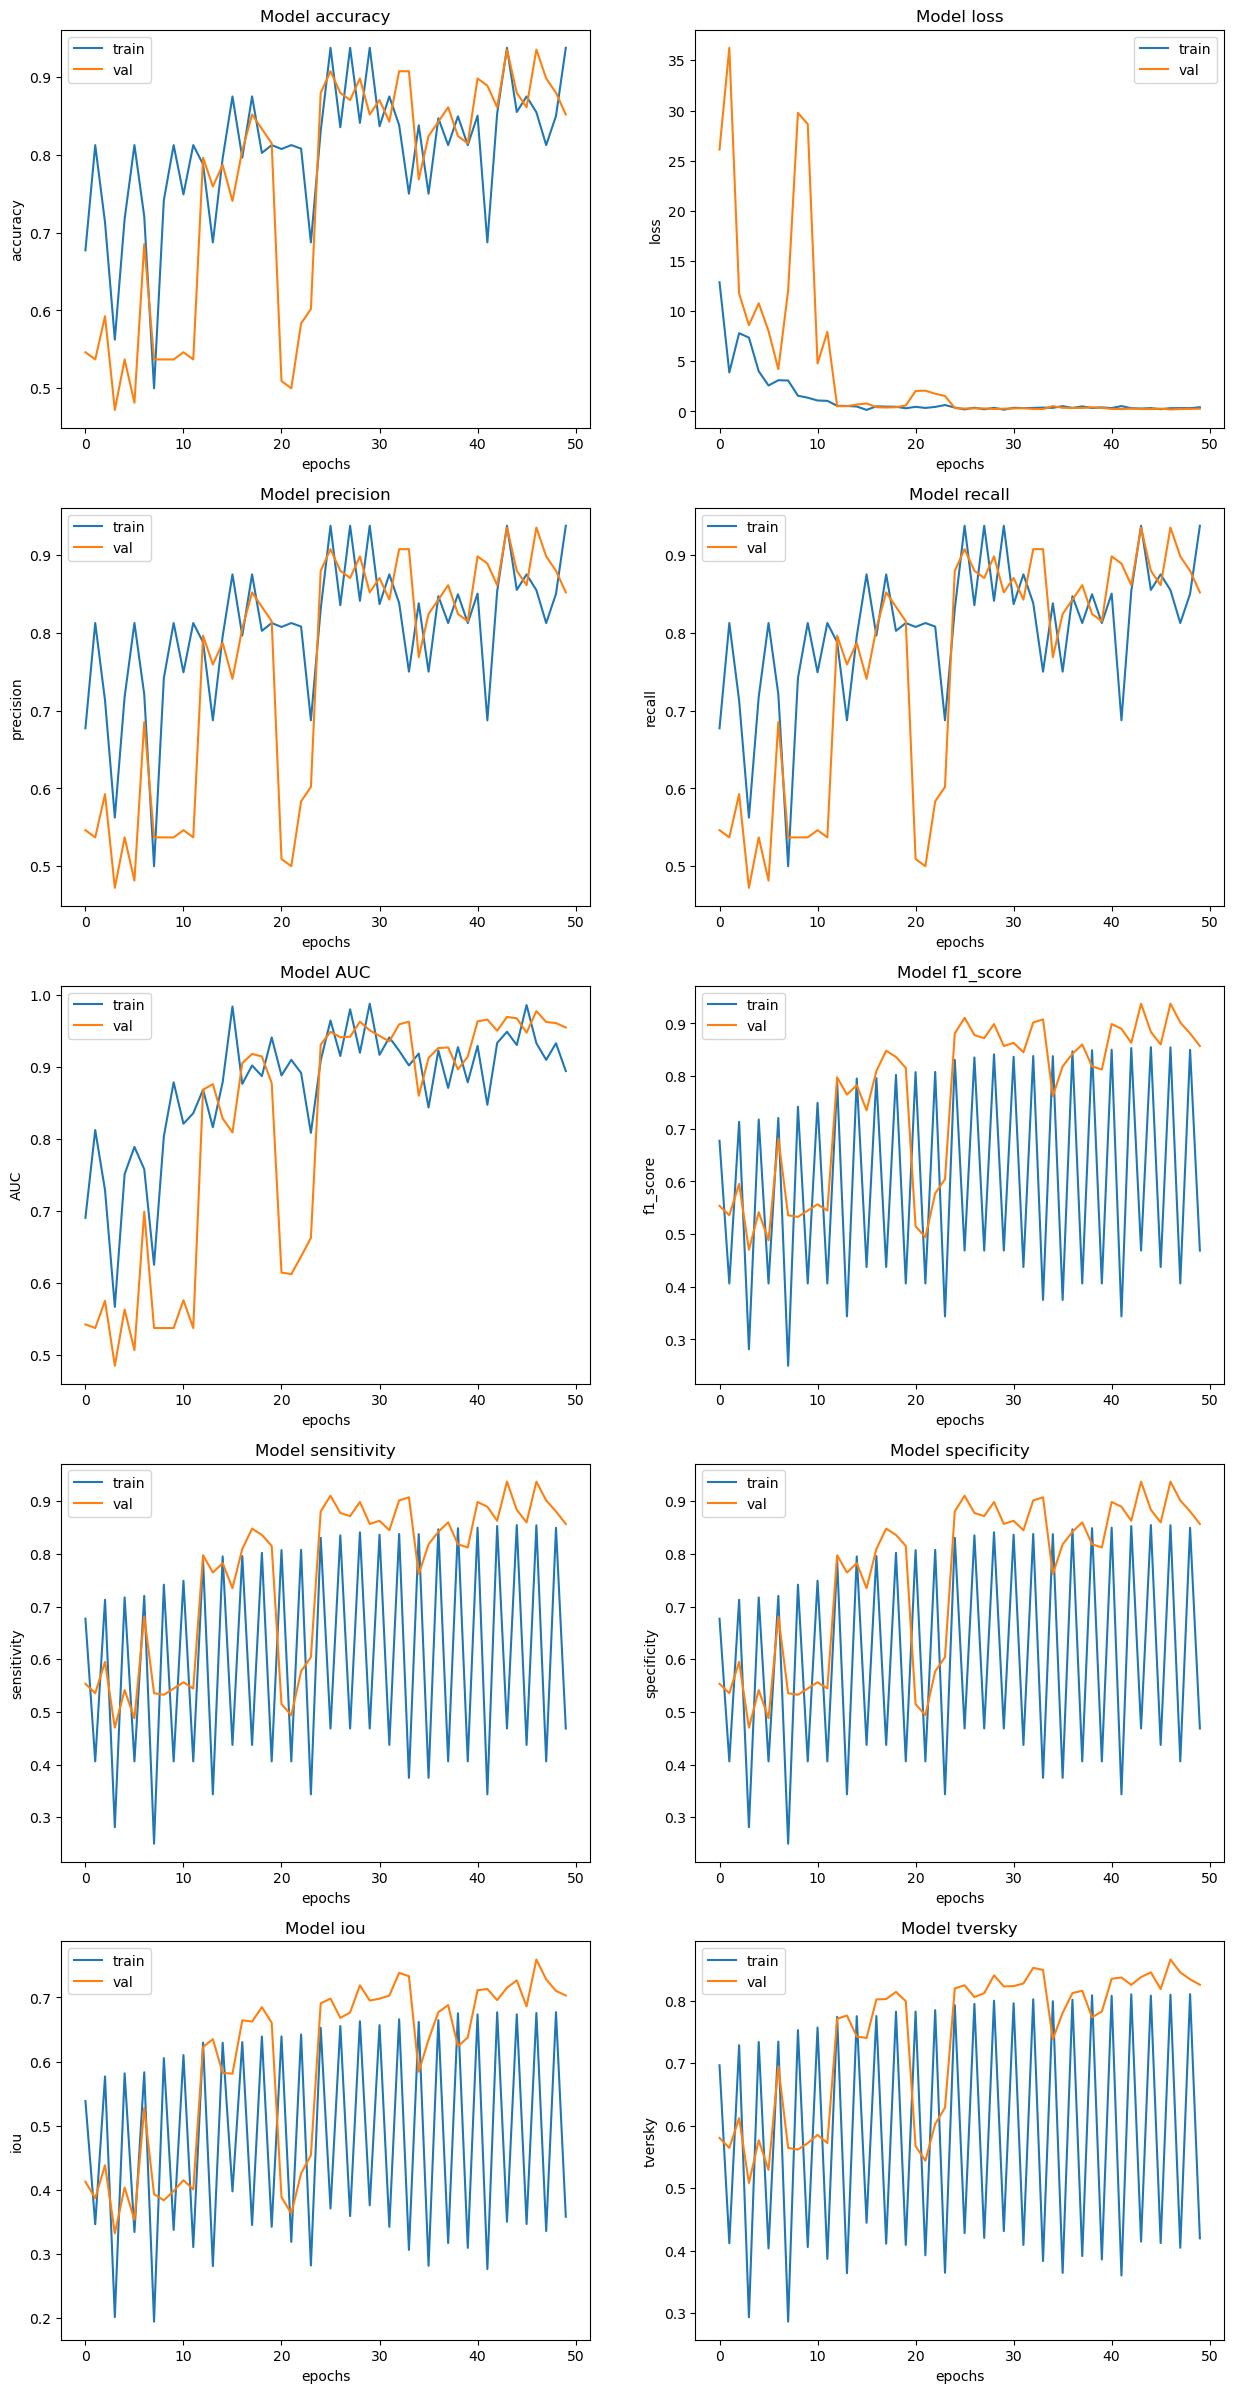

In [38]:
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC', 'f1_score', 'sensitivity', 'specificity', 'iou', 'tversky']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-Results.png")

Test_data = (data_gen.flow(X2_test, Y_test,
                          batch_size=128, 
                          seed=27,
                          shuffle=True))


In [39]:
print("Evaluate on test data")
results = model.evaluate(Test_data, batch_size=32, callbacks=callbacks)
print("test loss test acc:", results)

truey = []
predy = []
x = X2_test
y = Y_test

yhat = model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy) == yt[i].index(yyt)):
        count += 1

acc = (count / len(y)) * 100

Evaluate on test data


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - AUC: 0.9307 - accuracy: 0.8605 - f1_score: 0.8605 - iou: 0.6695 - loss: 0.3366 - precision: 0.8605 - recall: 0.8605 - sensitivity: 0.8605 - specificity: 0.8605 - tversky: 0.8027

2024-07-27 04:36:19.415870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - AUC: 0.9320 - accuracy: 0.8615 - f1_score: 0.8613 - iou: 0.6717 - loss: 0.3334 - precision: 0.8615 - recall: 0.8615 - sensitivity: 0.8613 - specificity: 0.8613 - tversky: 0.8041
test loss test acc: [0.3223995864391327, 0.8648925423622131, 0.8648925423622131, 0.8648925423622131, 0.9364088773727417, 0.8642939329147339, 0.8642939925193787, 0.8642939925193787, 0.6791070103645325, 0.809233546257019]
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step

2024-07-27 04:36:28.033301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step


In [40]:
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :" + str(acc) + "%")

Predicted and true label values saved
Accuracy on test set :87.81985670419652%


[[465  84]
 [ 35 393]]


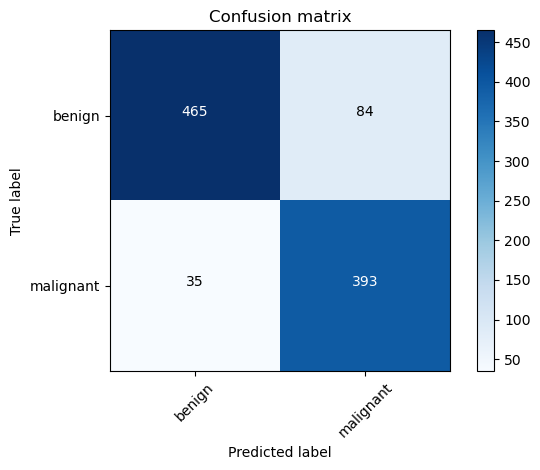

In [41]:
confusion_matrix_img(truey, predy, savename='Confusion Matrix')

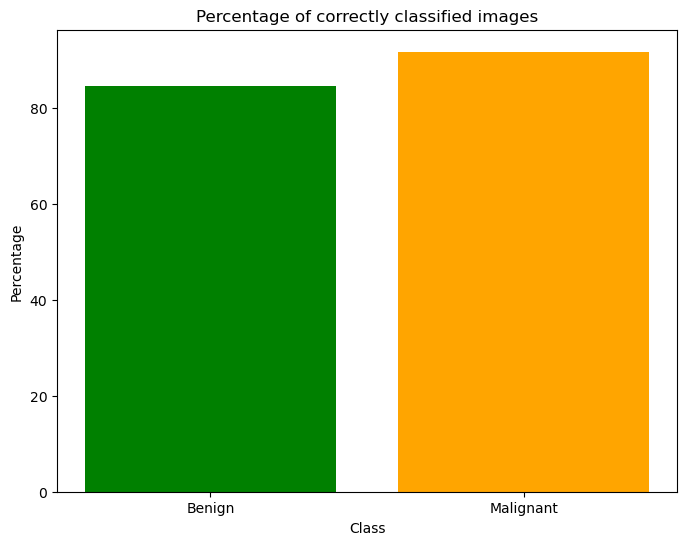

In [6]:
import matplotlib.pyplot as plt
accuracy_benign = 84.61  
accuracy_malignant = 91.82  

categories = ['Benign', 'Malignant']
accuracies = [accuracy_benign, accuracy_malignant]
colors = ['green', 'orange']

plt.figure(figsize=(8, 6))
plt.bar(categories, accuracies, color=colors)

plt.title('Percentage of correctly classified images')
plt.xlabel('Class')
plt.ylabel('Percentage')

plt.show()
